In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

train["LEN"] = train["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

train[["YR", "MON", "DAY", "HR", "WK"]] = train[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
train['CALL_TYPE'] = train['CALL_TYPE'].replace({'A':1, 'B':2, 'C':3})
train['DAY_TYPE'] = train['DAY_TYPE'].replace({'A':1, 'B':2, 'C':3})

In [7]:
stand_data = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

In [8]:
train = train.merge(stand_data, how='left', left_on='ORIGIN_STAND', right_on='ID')

In [9]:
train['MISSING_DATA'] = train['MISSING_DATA'].replace({True:1, False:0})
train = train.drop(['TRIP_ID', 'DAY_TYPE', 'TIMESTAMP', 'ORIGIN_CALL', 'Descricao', 'ID'], axis=1)
train = train[train['LEN']!=0]

train.loc[train['CALL_TYPE']==1, ['ORIGIN_STAND']] = 0
train.loc[train['CALL_TYPE']==3, ['ORIGIN_STAND']] = -1

In [56]:
train['ORIGIN_STAND'] = train['ORIGIN_STAND'].fillna(-1)

In [58]:
train.to_csv('cleaned_train.csv')

In [2]:
train = pd.read_csv('cleaned_train.csv', index_col=0)

In [3]:
mean, std = train["LEN"].mean(), train["LEN"].std()
median = train["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=732.0502550532805 median=615.0 std=683.8655961814885


In [4]:
outlier_threshold = 3
df_trimmed = train[train["LEN"] < mean + outlier_threshold * std]

In [5]:
mean, std = df_trimmed["LEN"].mean(), df_trimmed["LEN"].std()
median = df_trimmed["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=687.1129139168797 median=615.0 std=397.76575769779987


Text(0, 0.5, 'Number of Taxi Rides')

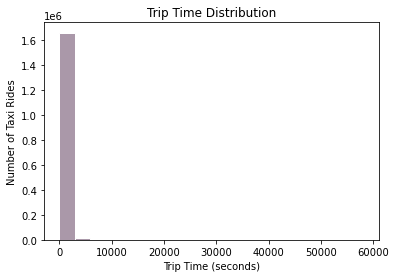

In [5]:
plt.hist(train['LEN'], bins=20, color='#AA98A9', edgecolor='white')
plt.title('Trip Time Distribution')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Number of Taxi Rides')

Text(0, 0.5, 'Number of Taxi Rides')

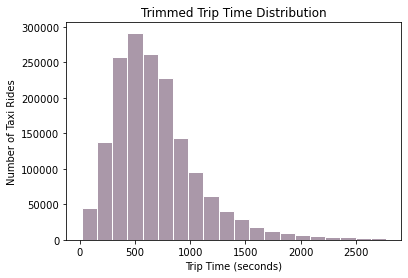

In [6]:
plt.hist(df_trimmed['LEN'], bins=20, color='#AA98A9', edgecolor='white')
plt.title('Trimmed Trip Time Distribution')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Number of Taxi Rides')

Text(0, 0.5, 'Number of Taxi Rides')

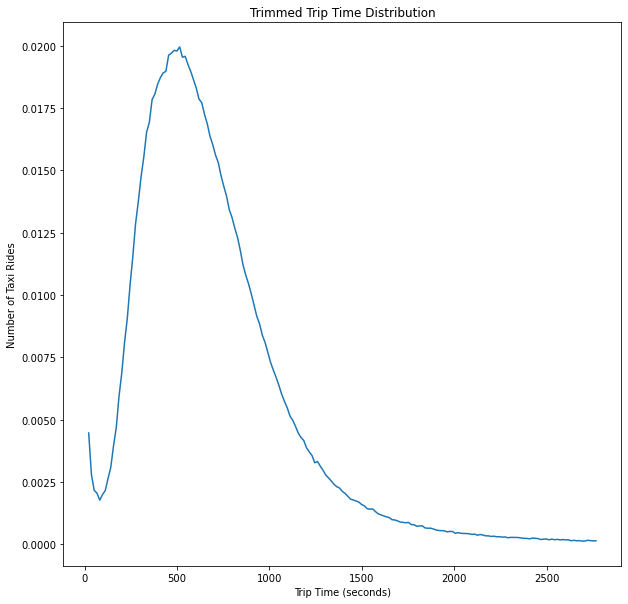

In [13]:
plt.figure(figsize=(10,10))
hourly_data = df_trimmed["LEN"]
buckets = (int(mean + outlier_threshold * std) // 15)
bins=20#buckets
histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
histogram = histogram / len(hourly_data)
# The center is the left_bound and right_bound of a bucket
bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
plt.plot(bin_centers, histogram)
plt.title('Trimmed Trip Time Distribution')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Number of Taxi Rides')

Text(0, 0.5, 'Number of Taxi Rides')

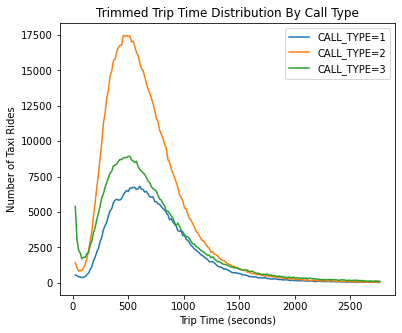

In [35]:
plt.figure(figsize=(6,5))
for v in [1, 2, 3]:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["CALL_TYPE"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    #histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"CALL_TYPE={v}")
plt.legend();
plt.title('Trimmed Trip Time Distribution By Call Type')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Number of Taxi Rides')

In [9]:
df_B = df_trimmed[df_trimmed['CALL_TYPE'] == 2]

In [10]:
df_B_cl = df_B.dropna(subset=['ORIGIN_STAND'])

In [11]:
stands = sorted(df_B_cl['ORIGIN_STAND'].unique())
len_stands = []
len_err = []
for i in stands:
    m = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].mean()
    s = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].std()
    len_stands.append(m)
    len_err.append(s)

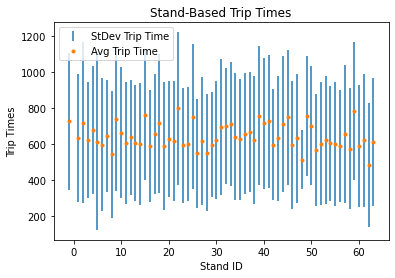

In [34]:
plt.errorbar(stands, len_stands, yerr=len_err, linestyle='None', label='StDev Trip Time')
plt.errorbar(stands, len_stands, linestyle='None', marker='.', label='Avg Trip Time')

plt.title('Stand-Based Trip Times')
plt.xlabel('Stand ID')
plt.ylabel('Trip Times')
plt.legend(loc='upper left')

In [3]:
import re

In [4]:
long = train['POLYLINE'].apply(lambda x: re.findall('\[(-\d+\.\d+),', x))

In [5]:
long_coords = []
for i in long:
    long_coords += i

In [6]:
long_coords = pd.cut(list(map(float,long_coords)), 10, retbins=True)

In [12]:
long = pd.DataFrame({'longitude':long_coords[0]})

In [13]:
long.to_csv('long.csv')

In [14]:
lat = train['POLYLINE'].apply(lambda x: re.findall('\,(\d+\.\d+)', x))

In [15]:
lat_coords = []
for i in lat:
    lat_coords += i

In [16]:
lat_coords = pd.cut(list(map(float,lat_coords)), 10, retbins=True)

In [17]:
lat = pd.DataFrame({'latitude':lat_coords[0]})

In [18]:
lat.to_csv('lat.csv')

In [19]:
binned_data = long.join(lat)

In [20]:
binned_data

,longitude,latitude
0,"(-9.781, -8.611]","(41.131, 42.547]"
1,"(-9.781, -8.611]","(41.131, 42.547]"
2,"(-9.781, -8.611]","(41.131, 42.547]"
3,"(-9.781, -8.611]","(41.131, 42.547]"
4,"(-9.781, -8.611]","(41.131, 42.547]"
...,...,...
83378772,"(-9.781, -8.611]","(41.131, 42.547]"
83378773,"(-9.781, -8.611]","(41.131, 42.547]"
83378774,"(-9.781, -8.611]","(41.131, 42.547]"
83378775,"(-9.781, -8.611]","(41.131, 42.547]"


In [21]:
binned_data[2] = np.ones(len(binned_data))

In [23]:
binned_data.to_csv('binned_data.csv')

In [24]:
mapped_data = binned_data.groupby(["longitude", "latitude"])[2].count().unstack()
log_mapped_data = mapped_data.apply(lambda x: np.log(x+1))

In [25]:
mapped_data

latitude,"(36.872, 38.301]","(38.301, 39.716]","(39.716, 41.131]","(41.131, 42.547]","(42.547, 43.962]","(43.962, 45.377]","(45.377, 46.792]","(46.792, 48.207]","(48.207, 49.622]","(49.622, 51.037]"
longitude,,,,,,,,,,
"(-15.642, -14.461]",0,0,0,0,1,0,0,0,0,0
"(-14.461, -13.291]",0,1,0,0,0,0,0,0,0,0
"(-13.291, -12.121]",0,1,0,0,0,0,1,0,0,0
"(-12.121, -10.951]",0,1,0,0,0,0,0,0,0,1
"(-10.951, -9.781]",1,0,0,0,1,0,0,0,0,0
"(-9.781, -8.611]",4,51486,1209137,47398314,0,2,0,0,0,0
"(-8.611, -7.441]",644,1630,1556864,33131604,0,0,0,0,0,0
"(-7.441, -6.271]",0,0,9902,19129,0,0,0,0,0,0
"(-6.271, -5.101]",1,1,1,46,0,1,0,0,0,0


In [26]:
import seaborn as sns

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

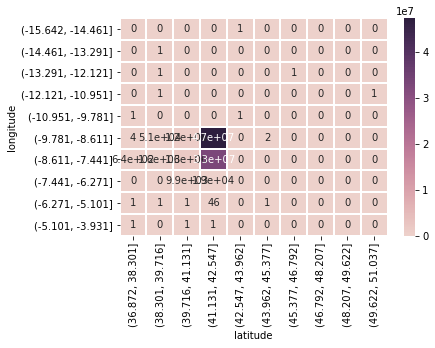

In [27]:
sns.heatmap(mapped_data, linewidths = 0.30, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))

Text(0.5, 1.0, 'Log of (Count+1) of Trip Position Coordinates')

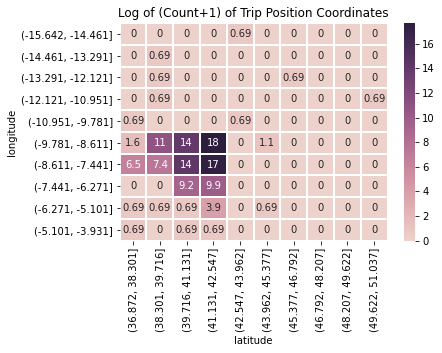

In [28]:
sns.heatmap(log_mapped_data, linewidths = 0.30, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Log of (Count+1) of Trip Position Coordinates')